### Loading the neccessary packages

In [1]:
import json
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import seaborn as sns
import calendar

### The following functions were written due to these reasons:

- **Objective**: The code was written to automate the detection and recovery of potential JSON formatting issues across multiple files and nested directory structures.
- **Use Case**: Correct JSON parsing.

#### `fix_json_file(input_file_path, output_file_path)`
- **Purpose**: This function fixes potential structural issues in a JSON file by ensuring it ends with a closing curly brace (`}`).
- **Why**: JSON files sometimes have structural issues like missing closing braces, which can cause parsing errors. This function aims to correct such issues to make the JSON valid to load.

#### `process_directory(input_dir, output_dir)`
- **Purpose**: This function processes all JSON files within a given directory (`input_dir`) and saves fixed versions of these files into an output directory (`output_dir`).
- **Why**: It allows batch processing of multiple JSON files within a directory structure. The `fix_json_file` function is utilized here to handle each JSON file individually.

#### `process_base_directory(base_dir, output_dir)`
- **Purpose**: This function processes all subfolders within a base directory (`base_dir`). For each subfolder, it calls `process_directory` to handle the JSON files within that subfolder.
- **Why**: This enables processing of nested directory structures, ensuring that all JSON files across multiple levels of folders are checked and fixed if necessary.

In [2]:
def fix_json_file(input_file_path, output_file_path):
    """Fixes structural issues in the JSON file."""
    try:
        with open(input_file_path, 'r') as file:
            data = file.read()

            if not data.endswith('}'):
                data += '}'
                
            json_data = json.loads(data)
            
        with open(output_file_path, 'w') as fixed_file:
            json.dump(json_data, fixed_file, indent=4)
            
        # print(f"Fixed JSON file saved as: {output_file_path}")
    except json.JSONDecodeError as e:
        pass
        # print(f"Error decoding JSON in {input_file_path}: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

def process_directory(input_dir, output_dir):
    """Processes all JSON files in the directory."""

    for root, _, files in os.walk(input_dir):
        relative_path = os.path.relpath(root, input_dir)
        output_sub_dir = os.path.join(output_dir, relative_path)

        if not os.path.exists(output_sub_dir):
            os.makedirs(output_sub_dir)

        for file_name in files:
            if file_name.endswith('.json'):
                input_file_path = os.path.join(root, file_name)
                output_file_path = os.path.join(output_sub_dir, file_name)

                fix_json_file(input_file_path, output_file_path)

def process_base_directory(base_dir, output_dir):
    """Processes all subfolders in the base directory."""

    for subfolder in os.listdir(base_dir):
        input_sub_dir = os.path.join(base_dir, subfolder)
        output_sub_dir = os.path.join(output_dir, subfolder)

        if os.path.isdir(input_sub_dir):
            process_directory(input_sub_dir, output_sub_dir)

base_directory = 'data'
output_directory = 'fixed_data'
process_base_directory(base_directory, output_directory)

print("Potential JSON files with formatting errors have been reformatted!")

Potential JSON files with formatting errors have been reformatted!


### Blink Data Extraction

#### `extract_blink_data(file_path)`
- This function extracts blink data from a JSON file (`file_path`) and prepares it for analysis.
- It retrieves the patient ID from the file path and reads the JSON data.
- Each blink event's timestamps (`t1` and `t2`) are processed to calculate blink durations, inter-blink durations, and blink rates.
- Invalid timestamps such as "Prompt" or "Breaktime" are ignored.
- The resulting data is formatted into a pandas DataFrame for further analysis.

#### `load_all_blink_data(base_folder)`
- This function loads blink data from all JSON files within a specified base folder (`base_folder`).
- It iterates through patient subfolders and JSON files to collect blink data using `extract_blink_data`.
- The collected data is aggregated into a pandas DataFrame that consolidates blink records across all patients and files.

In [3]:
def extract_blink_data(file_path):
    """
    Extracts blink data from a JSON file and prepares it for analysis.
    
    Parameters:
    - file_path (str): Path to the JSON file containing blink data.
    
    Returns:
    - List of dictionaries containing blink data for each blink event.
    """
    # Extract patient id from file path
    patient_id = os.path.basename(file_path).split('_')[0]
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Prepare data to load into DataFrame
    rows = []
    
    for timestamp, blink_list in data.items():
        try:
            start_timestamp_unix = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').timestamp()
            start_timestamp_human = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S')
            
        except ValueError:
            # Intended to ignore non standard timestamps: "Prompt1" and "Breaktime"
            continue
        
        if timestamp.startswith("Prompt") or timestamp == "Breaktime":
            continue 
        
        for blink in blink_list:
            try:
                t1 = int(blink['t1'])
                t2 = int(blink['t2'])
                
                rows.append({
                    'patient_id': patient_id,
                    'timestamp_unix_epoch': int(start_timestamp_unix * 1000), 
                    'timestamp_human_readable': start_timestamp_human, 
                    't1': t1,
                    't2': t2,
                })
                
            except KeyError as e:
                print(f"Missing key {e} in file: {file_path}")
                print(f"Offending data: {blink}")
                
            except ValueError as e:
                print(f"Value error: {e} in file: {file_path}")

    df = pd.DataFrame(rows)
    
    if df.empty:
        return [] 
    
    # Remove duplicate t1 values, keeping the first occurrence
    df = df.drop_duplicates(subset=['t1'], keep='first')

    # Sort dataframe by t1 within each patient
    df_sorted = df.sort_values(by=['patient_id', 't1']).reset_index(drop=True)
    
    # Calculate inter-blink durations
    interblink_durations = []
    previous_t2 = None
    previous_patient_id = None
    
    for idx, row in df_sorted.iterrows():
        if previous_t2 is not None and row['patient_id'] == previous_patient_id:
            interblink_duration_seconds = (row['t1'] - previous_t2) / 1000.0  # Convert milliseconds to seconds
        else:
            interblink_duration_seconds = None
        
        interblink_durations.append(interblink_duration_seconds)
        
        # Update previous values
        previous_t2 = row['t2']
        previous_patient_id = row['patient_id']
    
    # blink duration in seconds
    df_sorted['blink_duration_seconds'] = (df_sorted['t2'] - df_sorted['t1']) / 1000.0
    
    df_sorted['interblink_duration_seconds'] = interblink_durations

    # blink rate in blinks per seconds
    df_sorted['blink_rate'] = 1 / df_sorted['interblink_duration_seconds']
       
    # Handle NaN inter blink durations
    df_sorted.replace({'blink_rate': [float('inf'), -float('inf')]}, None, inplace=True)
    
    return df_sorted.to_dict(orient='records')

def load_all_blink_data(base_folder):
    """
    Loads all blink data from JSON files within a base folder.
    
    Parameters:
    - base_folder (str): Path to the base folder containing patient folders with JSON files.
    
    Returns:
    - DataFrame containing all blink data across patients and files.
    """
    blink_data = []
    for patient_folder in sorted(glob(os.path.join(base_folder, '*'))):
        for file_path in sorted(glob(os.path.join(patient_folder, '*.json'))):
            blink_data.extend(extract_blink_data(file_path))
            
    return pd.DataFrame(blink_data)

base_folder = 'fixed_data'
blink_data = load_all_blink_data(base_folder)
blink_data.head()

,patient_id,timestamp_unix_epoch,timestamp_human_readable,t1,t2,blink_duration_seconds,interblink_duration_seconds,blink_rate
0,2935156687,1714547058000,2024-05-01 12:34:18,1714547060529,1714547060865,0.336,NaN,NaN
1,2935156687,1714547058000,2024-05-01 12:34:18,1714547061006,1714547061089,0.083,0.141,7.092199
2,2935156687,1714547058000,2024-05-01 12:34:18,1714547067252,1714547086326,19.074,NaN,NaN
3,2935156687,1714547145000,2024-05-01 12:35:45,1714547148053,1714547148153,0.100,NaN,NaN
4,2935156687,1714547145000,2024-05-01 12:35:45,1714547150264,1714547150419,0.155,2.111,0.473709


In [4]:
blink_data.describe()

,timestamp_unix_epoch,t1,t2,blink_duration_seconds,interblink_duration_seconds,blink_rate
count,1.009610e+05,1.009610e+05,1.009610e+05,100961.000000,92998.000000,92998.000000
mean,1.714966e+12,1.714966e+12,1.714966e+12,1.086568,319.209613,1.711910
std,4.247456e+08,4.247665e+08,4.247664e+08,24.366721,1975.904595,2.142654
min,1.713207e+12,1.713207e+12,1.713207e+12,0.000000,0.046000,0.000019
25%,1.714715e+12,1.714715e+12,1.714715e+12,0.091000,0.437000,0.292826
50%,1.714987e+12,1.714987e+12,1.714987e+12,0.133000,1.178000,0.848896
75%,1.715335e+12,1.715335e+12,1.715335e+12,0.182000,3.415000,2.288330
max,1.717651e+12,1.717651e+12,1.717651e+12,1651.868000,53607.980000,21.739130


### Descriptive statistics:

#### Why did I check for Non negative values `Interblink Duration`:
It ensures data quality and maintains biological plausibility, since `t1` must be greater than `t2` which helps in early error identification.

In [5]:
print("Interblink duration statistics: \n")

negative_interblinks = blink_data[blink_data.interblink_duration_seconds < 0]
count_negative_interblinks = len(negative_interblinks)
print(f"Number of negative interblink durations: {count_negative_interblinks}")

# Count null values
null_count = blink_data.interblink_duration_seconds.isnull().sum()

# Count non-null values
non_null_count = blink_data.interblink_duration_seconds.notnull().sum()

print("Percentage of non-null values:", round(non_null_count / (null_count + non_null_count) * 100), "%")

Interblink duration statistics: 

Number of negative interblink durations: 0
Percentage of non-null values: 92 %


### Handling outliers:

- To analyze blink duration outliers, I calculated the interquartile range (IQR) and defined lower and upper bounds to filter out extreme values. 
- Filtered data is visualized using a boxplot, focusing on blink durations within acceptable ranges.

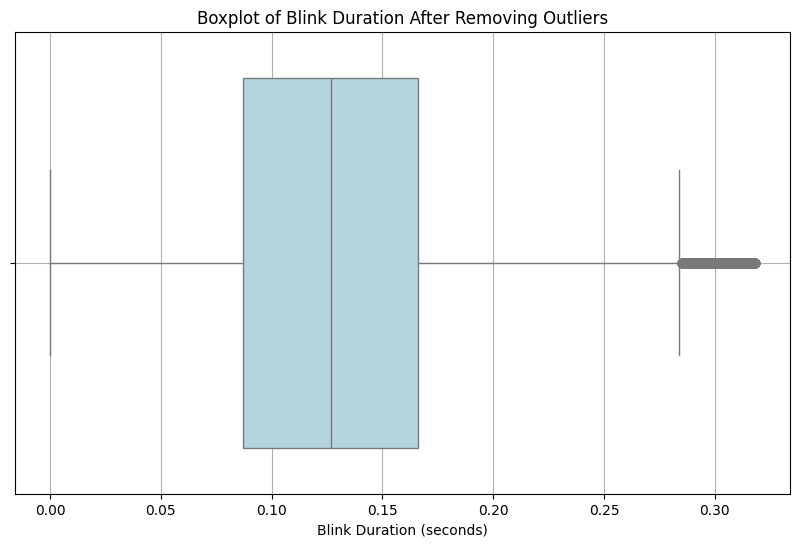

In [6]:
Q1 = blink_data['blink_duration_seconds'].quantile(0.25)
Q3 = blink_data['blink_duration_seconds'].quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering outliers
blink_duration_filtered_data = blink_data[(blink_data['blink_duration_seconds'] >= lower_bound) & (blink_data['blink_duration_seconds'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='blink_duration_seconds', data=blink_duration_filtered_data, color='lightblue')
plt.title('Boxplot of Blink Duration After Removing Outliers')
plt.xlabel('Blink Duration (seconds)')
plt.grid(True)
plt.show()

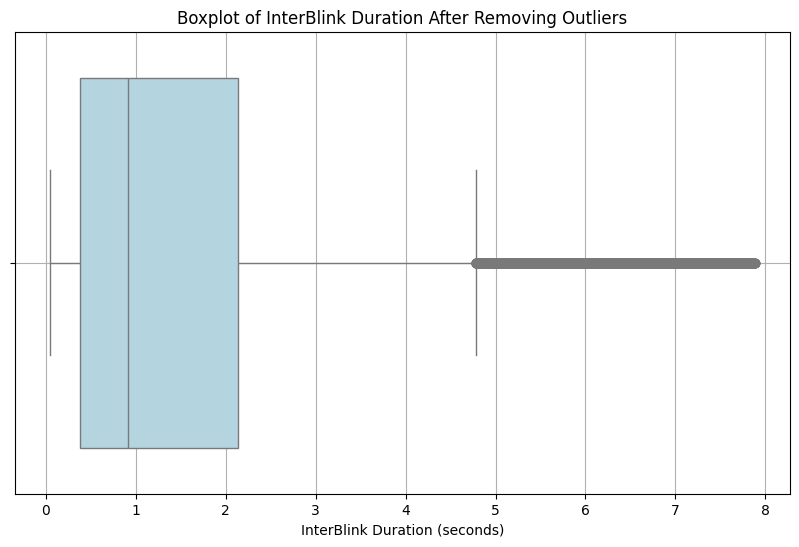

In [7]:
Q1 = blink_data['interblink_duration_seconds'].quantile(0.25)
Q3 = blink_data['interblink_duration_seconds'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

interblink_duration_filtered_data = blink_data[(blink_data['interblink_duration_seconds'] >= lower_bound) & (blink_data['interblink_duration_seconds'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='interblink_duration_seconds', data=interblink_duration_filtered_data, color='lightblue')
plt.title('Boxplot of InterBlink Duration After Removing Outliers')
plt.xlabel('InterBlink Duration (seconds)')
plt.grid(True)
plt.show()

### Categorizing Interblink Intervals:

Bar plot to illustrate the difference in blink rates between intervals less than 25 seconds and those 25 seconds or more.

/var/folders/6x/c19tq81j2954h_g4n73r3lp40000gn/T/ipykernel_5015/2322947312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blinks['interval'] = (filtered_blinks['interblink_duration_seconds'] >= 25).astype(int)


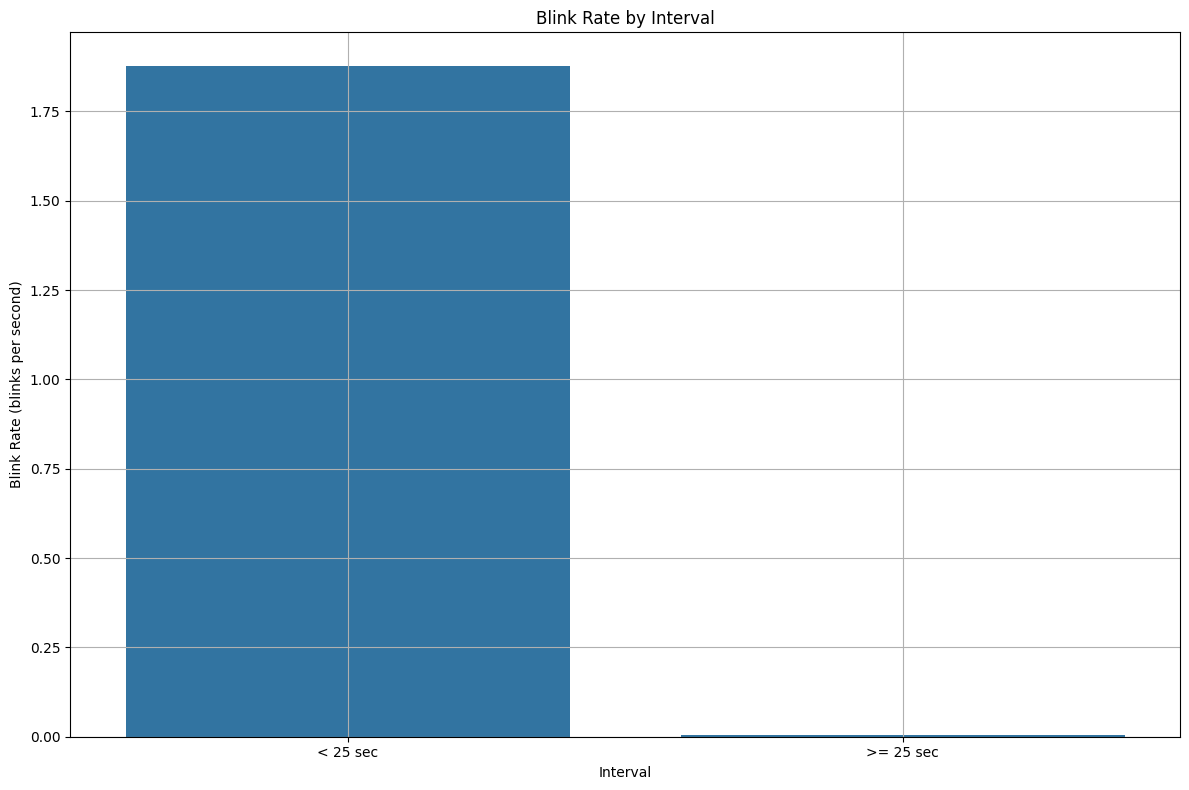

In [8]:
# Ensure interblink_duration is not None and in seconds
filtered_blinks = blink_data.dropna(subset=['interblink_duration_seconds'])

# Add interval column: 0 - within 25 seconds, 1 - beyond 25 seconds
filtered_blinks['interval'] = (filtered_blinks['interblink_duration_seconds'] >= 25).astype(int)

plt.figure(figsize=(12, 8))
sns.barplot(x='interval', y='blink_rate', data=filtered_blinks, errorbar=None, legend=False)
plt.xlabel('Interval')
plt.ylabel('Blink Rate (blinks per second)')
plt.title('Blink Rate by Interval')
plt.xticks([0, 1], ['< 25 sec', '>= 25 sec'])
plt.grid(True)
plt.tight_layout()
plt.show()

### KDE Plot of Blink Rate:

- KDE plot is generated to analyze the distribution and density of `blink rates` in the dataset. 
- It helps to identify patterns or clusters in blink rate frequencies, aiding in the exploration of the studied population.

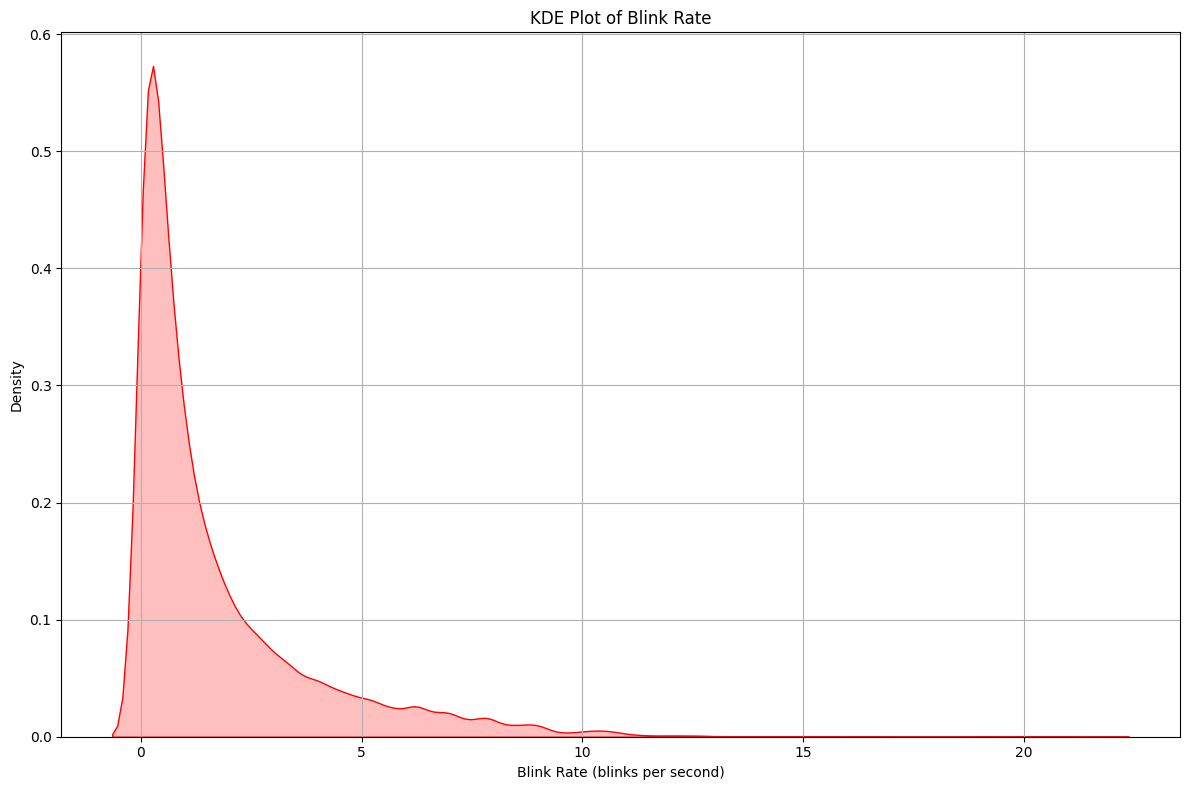

In [9]:
plt.figure(figsize=(12, 8))
sns.kdeplot(filtered_blinks['blink_rate'], fill=True, color='red')
plt.xlabel('Blink Rate (blinks per second)')
plt.ylabel('Density')
plt.title('KDE Plot of Blink Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


### KDE plot of Interblink Durations:

By examining this plot, insights can be gained into the variability and frequency of pauses between blinks, contributing to blinking patterns and behavior among the subjects.

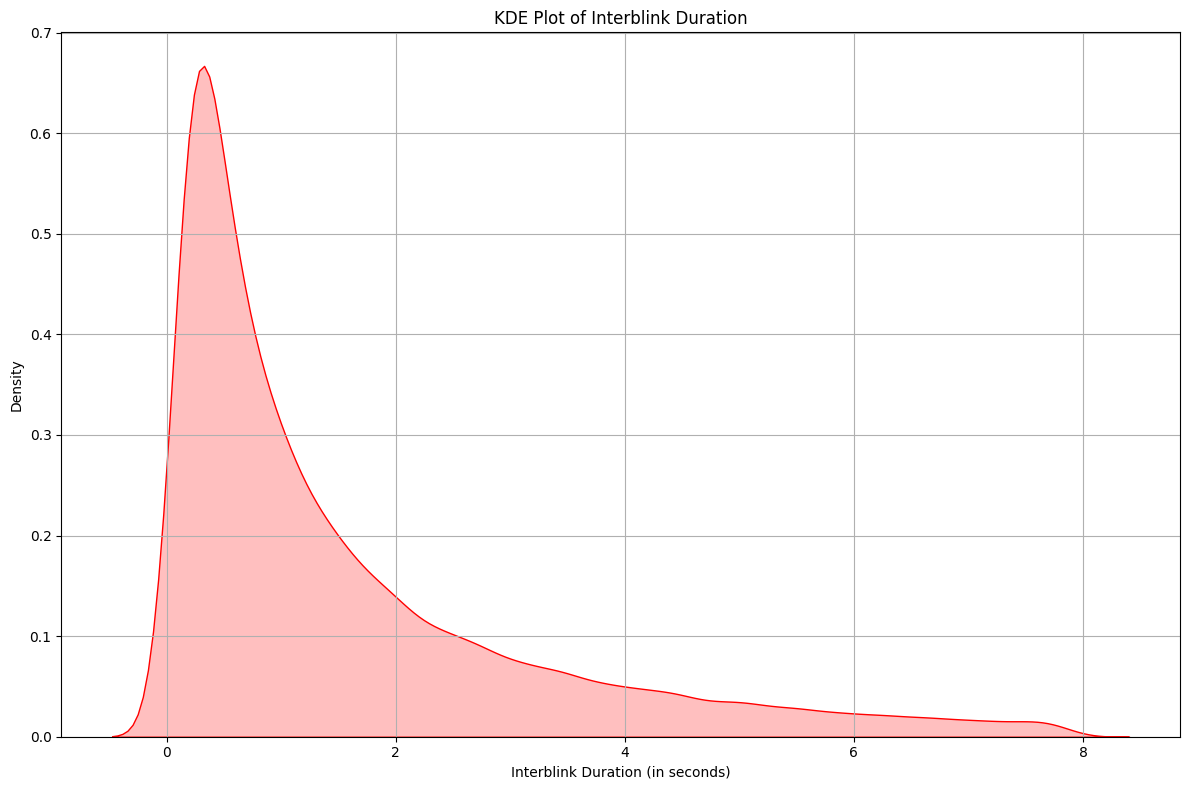

In [10]:
# KDE plot of interblink durations
plt.figure(figsize=(12, 8))
sns.kdeplot(interblink_duration_filtered_data['interblink_duration_seconds'], fill=True, color='red')
plt.xlabel('Interblink Duration (in seconds)')
plt.ylabel('Density')
plt.title('KDE Plot of Interblink Duration')
plt.grid(True)
plt.tight_layout()
plt.show()

### Distribution of Blink Durations:

By examining this plot, one can observe: <br>
a) central tendency <br>
b) variability, and <br>
c) shape of the blink duration distribution <br>
which aids in understanding the typical duration of blinks and any patterns or outliers present in the data.

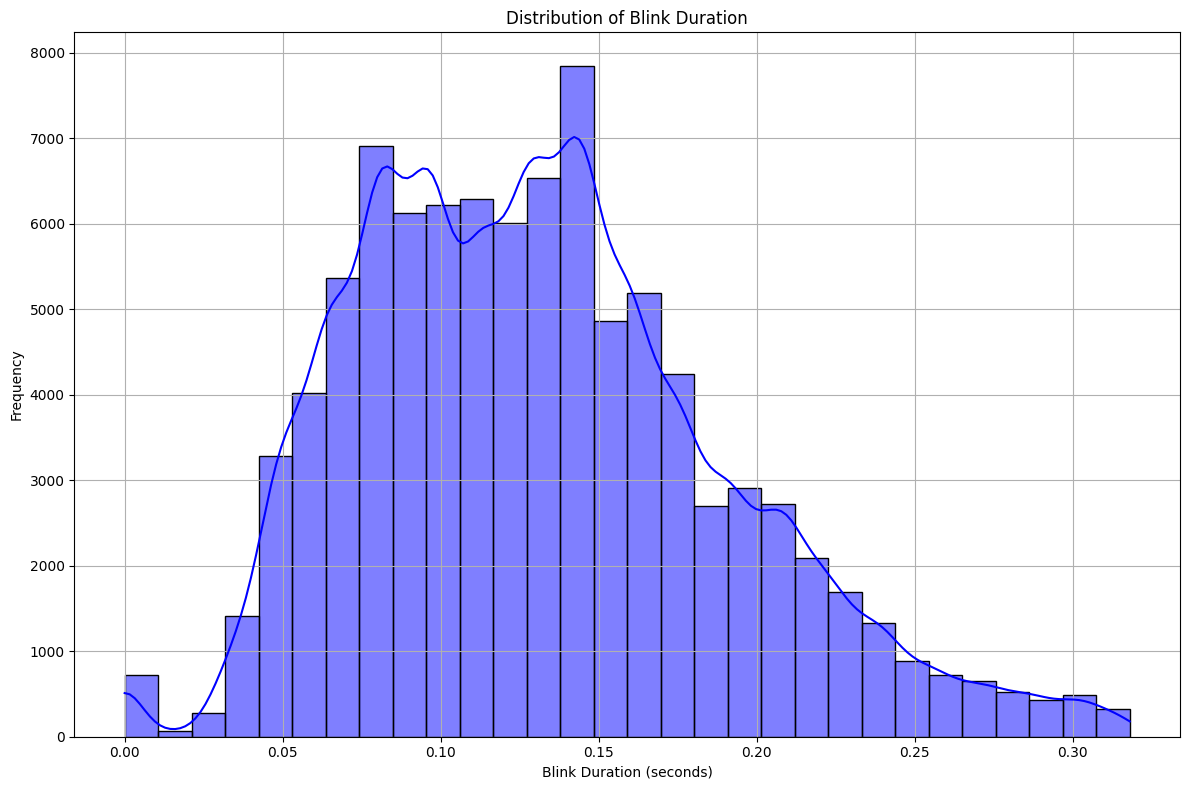

In [11]:
plt.figure(figsize=(12, 8))
sns.histplot(blink_duration_filtered_data['blink_duration_seconds'], bins=30, kde=True, color='blue')
plt.xlabel('Blink Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Blink Duration')
plt.grid(True)
plt.tight_layout()
plt.show()

### Distribution of Interblink Duration:
This histogram illustrates the distribution of interblink durations among the filtered blink data. Interblink duration refers to the time interval between successive blinks, measured in seconds. <br>

This analysis is crucial for quantitative insights into: <br>
a) How often individuals blink and <br>
b) Variability in their blink rates over time.

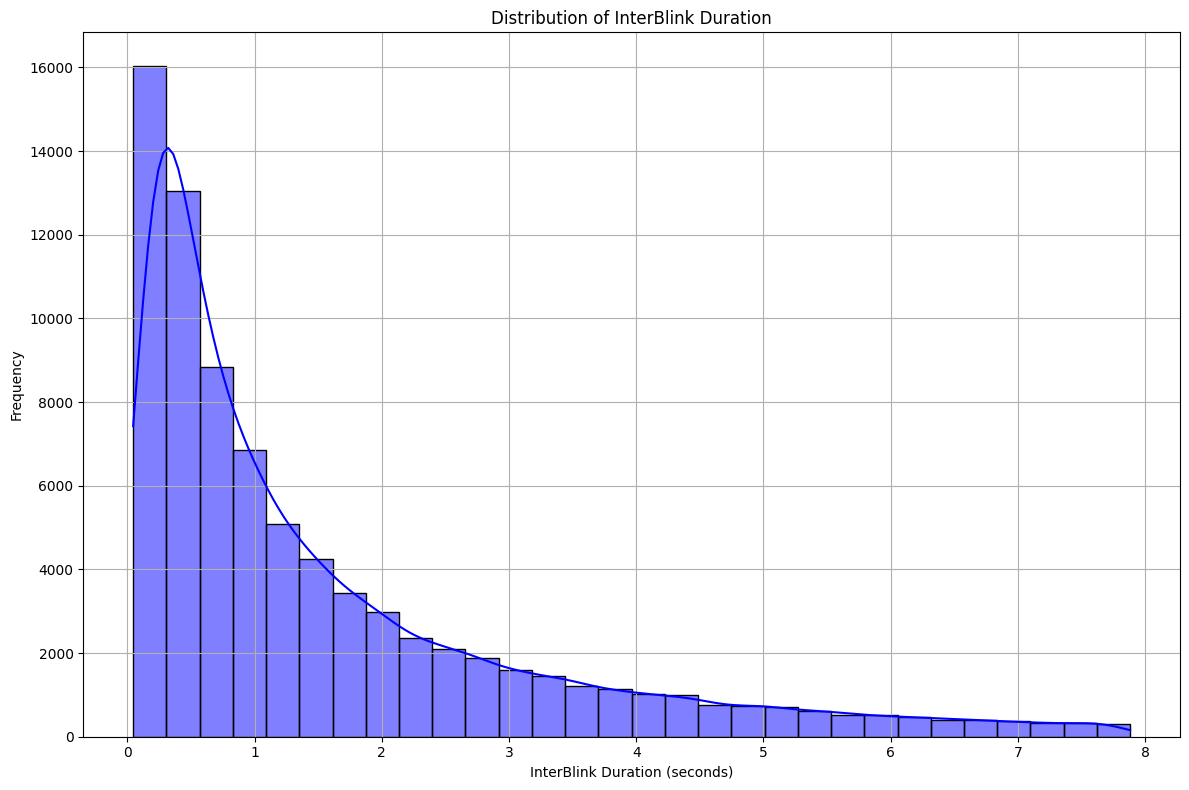

In [12]:
plt.figure(figsize=(12, 8))
sns.histplot(interblink_duration_filtered_data['interblink_duration_seconds'], bins=30, kde=True, color='blue')
plt.xlabel('InterBlink Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of InterBlink Duration')
plt.grid(True)
plt.tight_layout()

plt.show()

### Blink Rate of Subjects along Varying Blink Durations:

- Each point represents a combination of blink duration and blink rate for a specific subject. 
- The plot shows how blink duration relates to blink rate variability among individuals

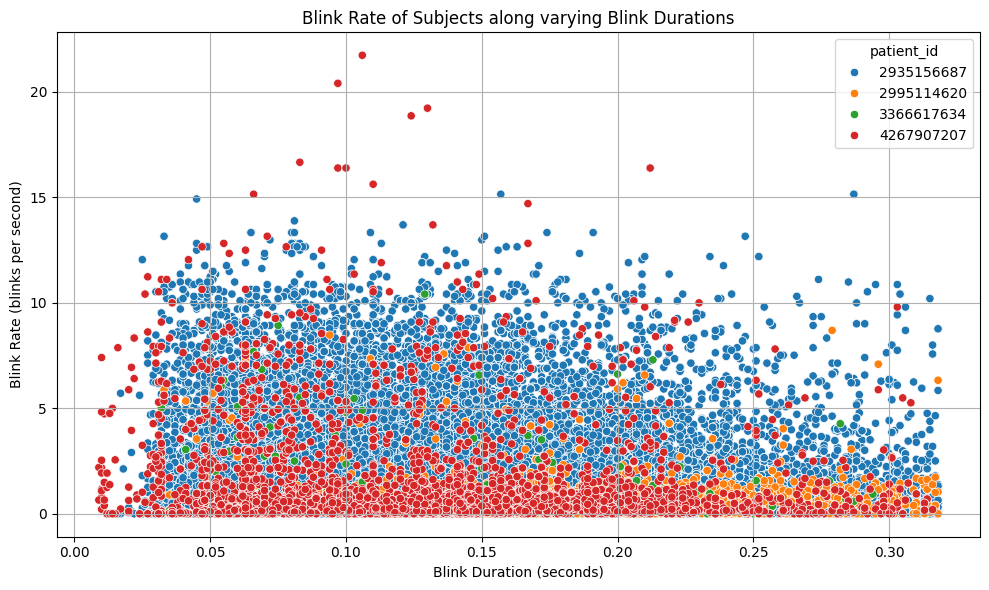

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=blink_duration_filtered_data, x='blink_duration_seconds', y='blink_rate', hue='patient_id')
plt.xlabel('Blink Duration (seconds)')
plt.ylabel('Blink Rate (blinks per second)')
plt.title('Blink Rate of Subjects along varying Blink Durations')
plt.grid(True)
plt.tight_layout()
plt.show()

### Case study: Analysis of Blink Rate Patterns Across Months
### How blink rate is affected in different months?

This analysis explores how blink rates vary across different months, aiming to:

1. Identify any seasonal or temporal patterns in blinking behavior. 
2. By plotting and examining blink rates over monthly intervals, this investigation provides insights into potential influences of external factors and conditions on blink frequency. 

Aim: Preliminary analysis to help aid for strategies for eye care and well-being management


In [14]:
# Convert 'timestamp' to datetime
interblink_duration_filtered_data['timestamp_human_readable'] = pd.to_datetime(interblink_duration_filtered_data['timestamp_human_readable'])

# Extract month from 'timestamp'
interblink_duration_filtered_data['month'] = interblink_duration_filtered_data['timestamp_human_readable'].dt.month
print(interblink_duration_filtered_data.head())

   patient_id  timestamp_unix_epoch timestamp_human_readable             t1  \
1  2935156687         1714547058000      2024-05-01 12:34:18  1714547061006   
4  2935156687         1714547145000      2024-05-01 12:35:45  1714547150264   
5  2935156687         1714547145000      2024-05-01 12:35:45  1714547152264   
6  2935156687         1714547145000      2024-05-01 12:35:45  1714547160248   
7  2935156687         1714547145000      2024-05-01 12:35:45  1714547160585   

              t2  blink_duration_seconds  interblink_duration_seconds  \
1  1714547061089                   0.083                        0.141   
4  1714547150419                   0.155                        2.111   
5  1714547152502                   0.238                        1.845   
6  1714547160312                   0.064                        7.746   
7  1714547160746                   0.161                        0.273   

   blink_rate  month  
1    7.092199      5  
4    0.473709      5  
5    0.542005    

/var/folders/6x/c19tq81j2954h_g4n73r3lp40000gn/T/ipykernel_5015/1020347354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interblink_duration_filtered_data['timestamp_human_readable'] = pd.to_datetime(interblink_duration_filtered_data['timestamp_human_readable'])
/var/folders/6x/c19tq81j2954h_g4n73r3lp40000gn/T/ipykernel_5015/1020347354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interblink_duration_filtered_data['month'] = interblink_duration_filtered_data['timestamp_human_readable'].dt.month


In [15]:
# Count the number of records per month
record_counts = interblink_duration_filtered_data['month'].value_counts().reset_index()
record_counts.columns = ['month', 'count']
record_counts = record_counts.sort_values(by='month')

monthly_blink_rate = interblink_duration_filtered_data.groupby('month')['blink_rate'].median().reset_index()

# Map month numbers to names
month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
             7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

record_counts['month_name'] = record_counts['month'].map(month_map)
monthly_blink_rate['month_name'] = monthly_blink_rate['month'].map(month_map)

print(record_counts)
print(monthly_blink_rate)

   month  count month_name
1      4   3034      April
0      5  77725        May
2      6     22       June
   month  blink_rate month_name
0      4    0.675449      April
1      5    1.112347        May
2      6    2.852050       June


/var/folders/6x/c19tq81j2954h_g4n73r3lp40000gn/T/ipykernel_5015/3074539263.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined_data, x='month_name', y='count', ax=ax1, palette='viridis', alpha=0.6)


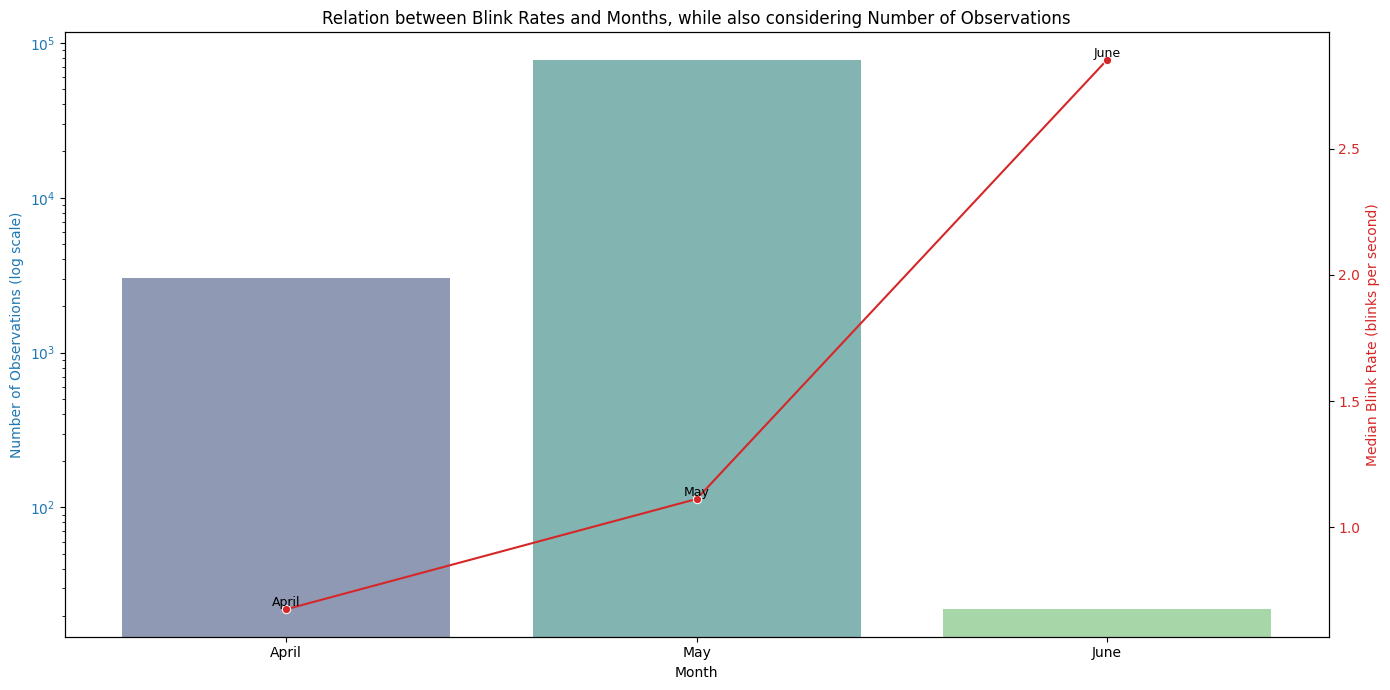

In [16]:
combined_data = pd.merge(record_counts, monthly_blink_rate, on='month')
combined_data['month_name'] = combined_data['month'].apply(lambda x: calendar.month_name[x])

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the number of records in log scale
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Observations (log scale)', color=color)
ax1.set_yscale('log')  # Set y-axis to logarithmic scale
sns.barplot(data=combined_data, x='month_name', y='count', ax=ax1, palette='viridis', alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Plot the blink rate on the same x-axis but different y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Median Blink Rate (blinks per second)', color=color)
sns.lineplot(data=combined_data, x='month_name', y='blink_rate', ax=ax2, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Annotate each point on the line plot with the month name
for index, row in combined_data.iterrows():
    ax2.text(row['month_name'], row['blink_rate'], row['month_name'], ha='center', va='bottom', fontsize=9, color='black')

plt.title('Relation between Blink Rates and Months, while also considering Number of Observations')
fig.tight_layout()
plt.show()

1. **Monthly Record Counts**: 
   - In May, the number of records is significantly higher compared to April and June.
   - April has the lowest count of records among the three months.

2. **Monthly Blink Rates**:
   - June shows the highest average blink rate, followed by May and April.
   - There appears to be an increasing trend in blink rates from April to June.

**Conclusion:**
- May had the highest number of recorded instances, indicating possibly more data collection during that month.
- June exhibited the highest average blink rate, suggesting potential variations in blinking behavior across different months.

### Thank you for going through the notebook!

In [17]:
# Extract month from the timestamp
interblink_duration_filtered_data['month'] = pd.to_datetime(interblink_duration_filtered_data['timestamp_human_readable']).dt.month

# Group by month and count distinct patient IDs
monthly_patient_count = interblink_duration_filtered_data.groupby('month')['patient_id'].value_counts().reset_index()
monthly_patient_count.rename(columns={'patient_id': 'unique_patient_id'}, inplace=True)

# Print the result to see the unique patient count per month
print(monthly_patient_count)

   month unique_patient_id  count
0      4        4267907207   3034
1      5        2935156687  74987
2      5        2995114620   1952
3      5        4267907207    646
4      5        3366617634    140
5      6        4267907207     22


/var/folders/6x/c19tq81j2954h_g4n73r3lp40000gn/T/ipykernel_5015/3566644421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interblink_duration_filtered_data['month'] = pd.to_datetime(interblink_duration_filtered_data['timestamp_human_readable']).dt.month


In [18]:
# Merge the patient count data with the combined_data
combined_data = pd.merge(combined_data, monthly_patient_count, on='month')

# Add month names
combined_data['month_name'] = combined_data['month'].apply(lambda x: calendar.month_name[x])

# Print combined_data to verify
print(combined_data)

   month  count_x month_name_x  blink_rate month_name_y month_name  \
0      4     3034        April    0.675449        April      April   
1      5    77725          May    1.112347          May        May   
2      5    77725          May    1.112347          May        May   
3      5    77725          May    1.112347          May        May   
4      5    77725          May    1.112347          May        May   
5      6       22         June    2.852050         June       June   

  unique_patient_id  count_y  
0        4267907207     3034  
1        2935156687    74987  
2        2995114620     1952  
3        4267907207      646  
4        3366617634      140  
5        4267907207       22  


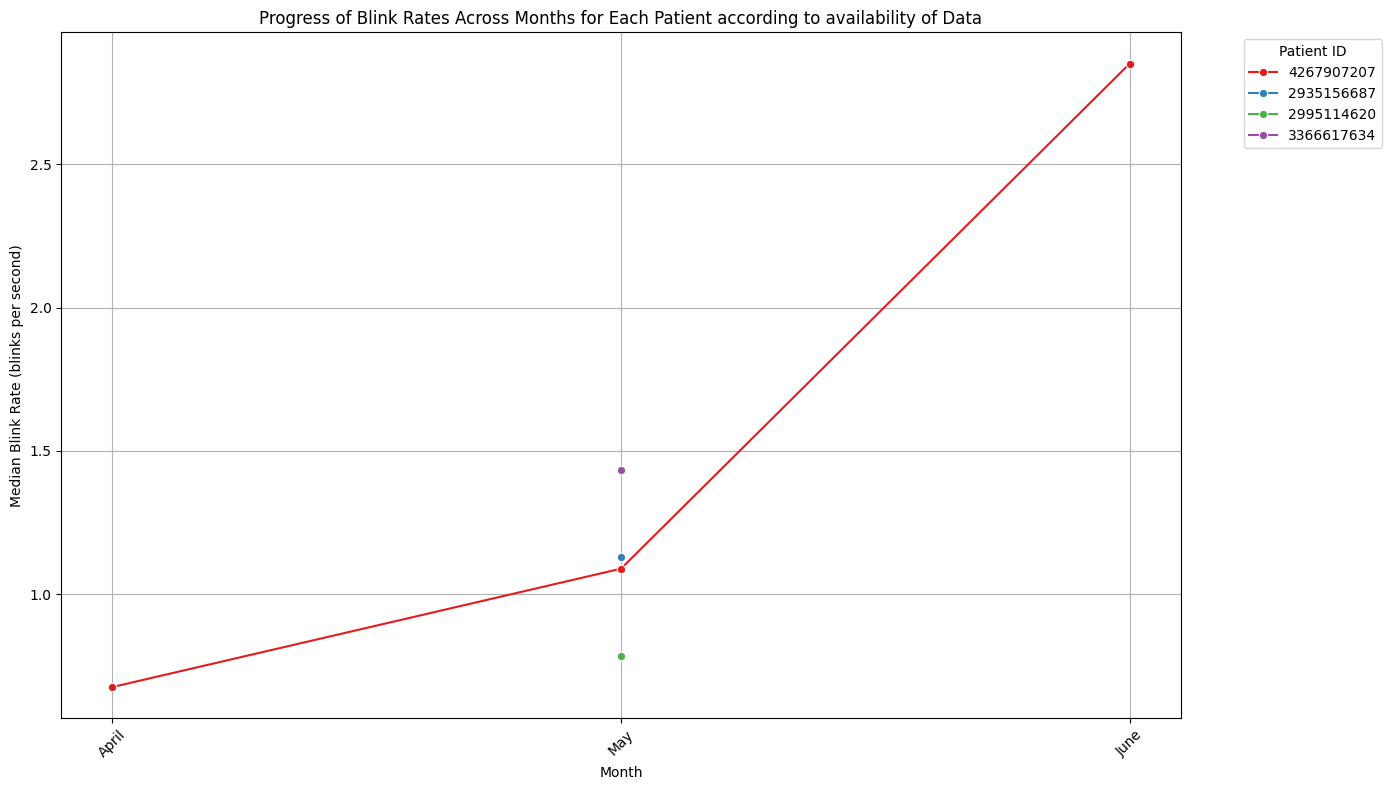

In [19]:
# Calculate median blink rate per patient per month
median_blink_rate = interblink_duration_filtered_data.groupby(['patient_id', 'month'])['blink_rate'].median().reset_index()

# Map numeric month values to month names
median_blink_rate['month_name'] = median_blink_rate['month'].apply(lambda x: calendar.month_name[x])

# Define the order of months
month_order = [calendar.month_name[4], calendar.month_name[5], calendar.month_name[6]]

# Sort the DataFrame by month order
median_blink_rate['month_name'] = pd.Categorical(median_blink_rate['month_name'], categories=month_order, ordered=True)
median_blink_rate = median_blink_rate.sort_values('month_name')

# Plotting the progress of blink rates across months for each patient
plt.figure(figsize=(14, 8))
sns.lineplot(data=median_blink_rate, x='month_name', y='blink_rate', hue='patient_id', marker='o', palette='Set1', errorbar=None)
plt.xlabel('Month')
plt.ylabel('Median Blink Rate (blinks per second)')
plt.title('Progress of Blink Rates Across Months for Each Patient according to availability of Data')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

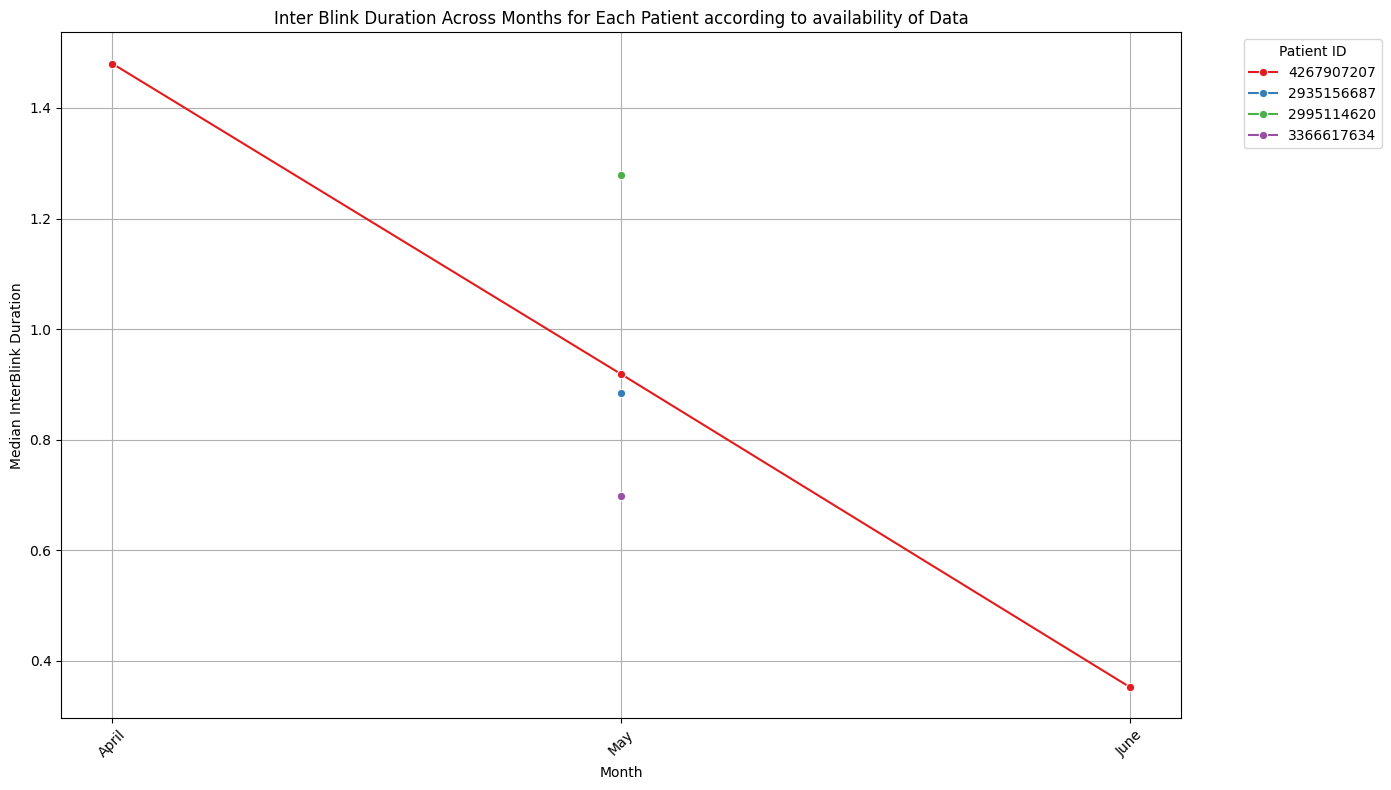

In [20]:
# Calculate median blink rate per patient per month
median_interblink = interblink_duration_filtered_data.groupby(['patient_id', 'month'])['interblink_duration_seconds'].median().reset_index()

# Map numeric month values to month names
median_interblink['month_name'] = median_interblink['month'].apply(lambda x: calendar.month_name[x])

# Define the order of months
month_order = [calendar.month_name[4], calendar.month_name[5], calendar.month_name[6]]

# Sort the DataFrame by month order
median_interblink['month_name'] = pd.Categorical(median_interblink['month_name'], categories=month_order, ordered=True)
median_interblink= median_interblink.sort_values('month_name')

# Plotting the progress of blink rates across months for each patient
plt.figure(figsize=(14, 8))
sns.lineplot(data=median_interblink, x='month_name', y='interblink_duration_seconds', hue='patient_id', marker='o', palette='Set1', errorbar=None)
plt.xlabel('Month')
plt.ylabel('Median InterBlink Duration')
plt.title('Inter Blink Duration Across Months for Each Patient according to availability of Data')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

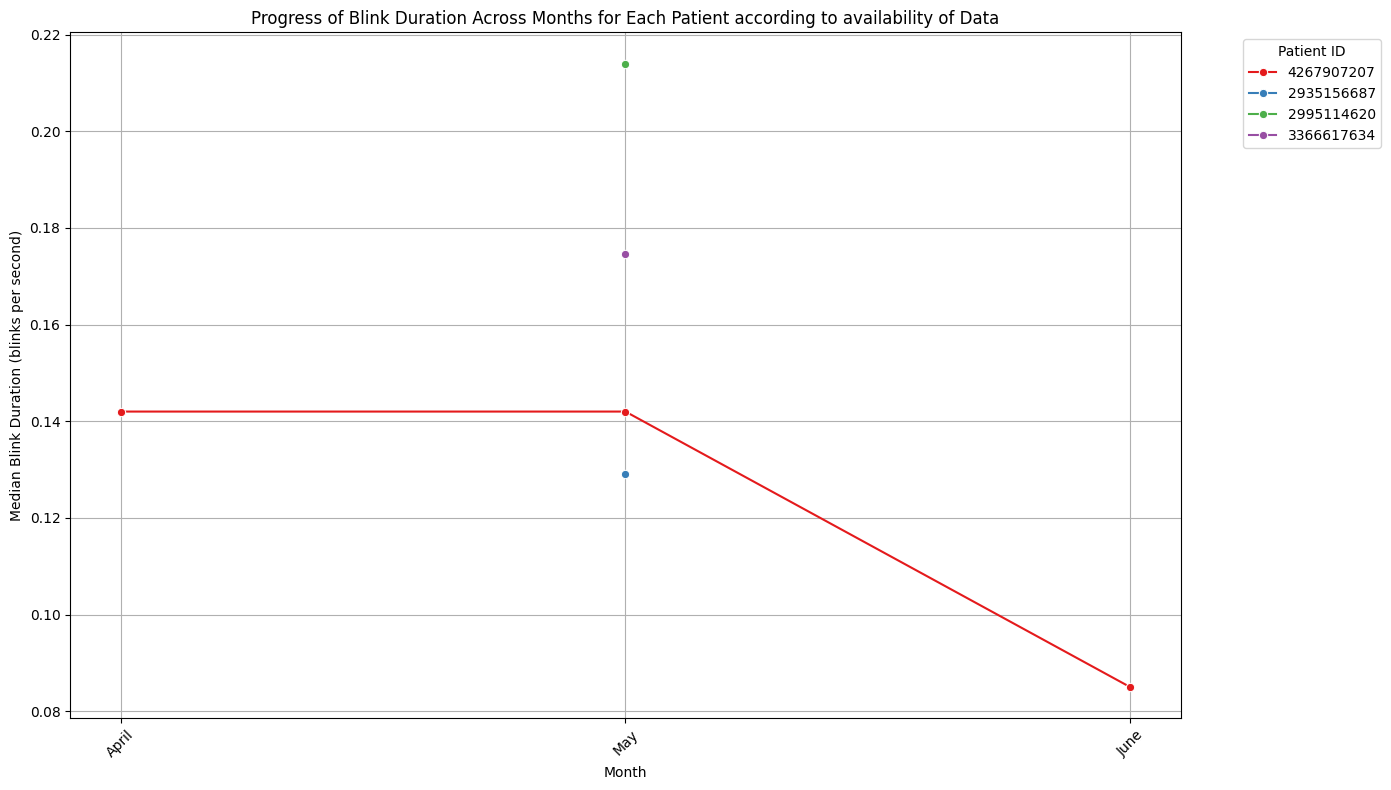

In [21]:
# Calculate median blink rate per patient per month
median_blink_duration = interblink_duration_filtered_data.groupby(['patient_id', 'month'])['blink_duration_seconds'].median().reset_index()

# Map numeric month values to month names
median_blink_duration['month_name'] = median_blink_duration['month'].apply(lambda x: calendar.month_name[x])

# Define the order of months
month_order = [calendar.month_name[4], calendar.month_name[5], calendar.month_name[6]]

# Sort the DataFrame by month order
median_blink_duration['month_name'] = pd.Categorical(median_blink_duration['month_name'], categories=month_order, ordered=True)
median_blink_duration = median_blink_duration.sort_values('month_name')

# Plotting the progress of blink rates across months for each patient
plt.figure(figsize=(14, 8))
sns.lineplot(data=median_blink_duration, x='month_name', y='blink_duration_seconds', hue='patient_id', marker='o', palette='Set1', errorbar=None)
plt.xlabel('Month')
plt.ylabel('Median Blink Duration (blinks per second)')
plt.title('Progress of Blink Duration Across Months for Each Patient according to availability of Data')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()